# Unstacking 2 Overlayed Images

## Import Statements

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
import torchvision
from torchvision import transforms
from d2l import torch as d2l
import random
import matplotlib.pyplot as plt

## Dataset

### Getting Fashion MNIST Dataset

In [20]:
transform = transforms.ToTensor() # The transform to convert images to tensors
fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform) # Load training dataset

### Class that overlays pairs of Fashion MNIST images and returns the overlayed image and the original images

In [ ]:
class OverlayDataset(Dataset):
    def __init__(self, base_dataset, num_pairs=None): # Initialize OverlayDataset
        self.base = base_dataset # Base dataset to create overlays from
        N = len(base_dataset) # Total number of images in the base dataset
        self.num_pairs = num_pairs if num_pairs else N - 1 # Number of overlay pairs
        self.pairs = torch.randint(0, N, (self.num_pairs, 2)) # Randomly generate pairs of indices
        mask = self.pairs[:,0] == self.pairs[:,1] # Find pairs where both indices are the same
        self.pairs[mask,1] = (self.pairs[mask,1] + 1) % N # Ensure indices in a pair are not the same by modifying the second index

    def __len__(self): # Length of the dataset
        return self.num_pairs # Returns the number of overlay pairs

    def __getitem__(self, idx): # Get item at index idx
        i, j = self.pairs[idx] # Get indices for the pair
        imgA, _ = self.base[i] # Get first image
        imgB, _ = self.base[j] # Get second image
        overlay = 0.5 * imgA + 0.5 * imgB # Create overlay by averaging pixel values
        return overlay, imgA, imgB # Return overlay and original images

### Creates dataset of overlayed images

In [51]:
overlay_dataset = OverlayDataset(fashion_mnist_train, num_pairs=20000) # Create overlay dataset with 20,000 pairs of images

### Splits the overlayed dataset into training, validation, and testing

In [52]:
train_size = int(0.8 * len(overlay_dataset)) # Size of training set (80% of dataset)
val_size   = int(0.1 * len(overlay_dataset)) # Size of validation set (10% of dataset)
test_size  = len(overlay_dataset) - train_size - val_size # Size of test set (remaining 10%)

# Split dataset into train, val, test sets using random_split
train_set, val_set, test_set = random_split(
    overlay_dataset, [train_size, val_size, test_size]
)

### Creates dataloaders for training, validation, and testing datasets

In [53]:
batch_size = 32 # Define batch size for data loaders

# Create dataloader for train set using DataLoader
train_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in train_set],
    batch_size=batch_size, shuffle=True
)
# Create dataloader for val set using DataLoader
val_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in val_set],
    batch_size=batch_size, shuffle=False
)
# Create dataloader for test set using DataLoader
test_loader = torch.utils.data.DataLoader(
    [(overlay, imgA, imgB) for overlay, imgA, imgB in test_set],
    batch_size=batch_size, shuffle=False
)

## CNN Model

### Defines the residual separator CNN model, which uses residual connections and has two output branches for the two predicted images

In [54]:
class ResidualSeparatorCNN(nn.Module):
    # Initialize the neural network
    def __init__(self):
        super().__init__() # Call the parent class constructor

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1) # First convolutional layer, input channels=1, output channels=64, kernel size=3, padding=1
        self.bn1 = nn.BatchNorm2d(64) # Batch normalization for 64 channels, helps in stabilizing and speeding up training

        # First residual block, handles simple features
        self.res1_conv1 = nn.Conv2d(64, 128, 3, padding=1) # First conv layer of first residual block, increases channels from 64 to 128 to capture more features
        self.res1_bn1 = nn.BatchNorm2d(128) # Batch normalization for 128 channels
        self.res1_conv2 = nn.Conv2d(128, 64, 3, padding=1) # Second conv layer of first residual block, reduces channels back to 64 to match input for residual connection
        self.res1_bn2 = nn.BatchNorm2d(64) # Batch normalization for 64 channels

        # Second residual block, handles more complex features
        self.res2_conv1 = nn.Conv2d(64, 128, 3, padding=1) # First conv layer of second residual block, increases channels from 64 to 128 to capture more complex features
        self.res2_bn1   = nn.BatchNorm2d(128) # Batch normalization for 128 channels
        self.res2_conv2 = nn.Conv2d(128, 64, 3, padding=1) # Second conv layer of second residual block, reduces channels back to 64 to match input for residual connection
        self.res2_bn2   = nn.BatchNorm2d(64) # Batch normalization for 64 channels

        # Branch for outputting first separated image
        self.branchA = nn.Sequential( # Sequential container for branch A
            nn.Conv2d(64, 32, 3, padding=1), # Conv layer reducing channels from 64 to 32
            nn.ReLU(), # ReLU activation function, introduces non-linearity
            nn.Conv2d(32, 1, 3, padding=1), # Conv layer reducing channels from 32 to 1 for grayscale output
            nn.Sigmoid() # Sigmoid activation to ensure output pixel values are between 0 and 1, suitable for FashionMNIST images
        )

        # Branch for outputting second separated image
        self.branchB = nn.Sequential( # Sequential container for branch B
            nn.Conv2d(64, 32, 3, padding=1), # Conv layer reducing channels from 64 to 32
            nn.ReLU(), # ReLU activation function, introduces non-linearity
            nn.Conv2d(32, 1, 3, padding=1), # Conv layer reducing channels from 32 to 1 for grayscale output
            nn.Sigmoid() # Sigmoid activation to ensure output pixel values are between 0 and 1, suitable for FashionMNIST images
        )

    # Define forward pass
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # Initial conv layer with ReLU activation

        # Residual block 1, handles simple features
        res = F.relu(self.res1_bn1(self.res1_conv1(out))) # First conv layer of first residual block with ReLU activation
        res = self.res1_bn2(self.res1_conv2(res)) # Second conv layer of first residual block
        out = F.relu(out + res) # Add residual and apply ReLU activation, helps with gradient flow and learning identity mappings

        # Residual block 2, handles more complex features
        res = F.relu(self.res2_bn1(self.res2_conv1(out))) # First conv layer of second residual block with ReLU activation
        res = self.res2_bn2(self.res2_conv2(res)) # Second conv layer of second residual block
        out = F.relu(out + res) # Add residual and apply ReLU activation, helps with gradient flow and learning identity mappings

        # Branch outputs
        outA = self.branchA(out) # Pass through branch A to get first separated image
        outB = self.branchB(out) # Pass through branch B to get second separated image

        return outA, outB # Return both separated images

### Loss Function

In [55]:
# Define separation loss function using L1 loss
def separation_loss_l1(predA, predB, imgA, imgB):
    loss1 = F.l1_loss(predA, imgA) + F.l1_loss(predB, imgB) # L1 loss for first assignment, predA to imgA and predB to imgB
    loss2 = F.l1_loss(predA, imgB) + F.l1_loss(predB, imgA) # L1 loss for second assignment, predA to imgB and predB to imgA
    return torch.min(loss1, loss2) # Return the minimum loss to account for permutation invariance

### Device

In [ ]:
if torch.backends.mps.is_available(): # Check if MPS (Apple Silicon) is available
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda") # Use GPU if available 
else:
    device = torch.device("cpu") # Fallback to CPU if no GPU is available

print("Using device:", device) # Print the device being used 

model = ResidualSeparatorCNN().to(device) # Instantiate model and move to device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer for training, learning rate of 0.001

Using device: mps


## Displaying Results

In [57]:
# Shows the results of the model on the overlay dataset
def show_overlay_results(model, dataset, index=0):
    """
    Display:
    - Overlay input
    - Original images A and B
    - Predicted images A and B
    """
    model.eval() # set model to evaluation mode
    
    # Get overlay and original images
    overlay, imgA, imgB = dataset[index]
    
    # Add batch dimension and move to device
    overlay_batch = overlay.unsqueeze(0).to(next(model.parameters()).device) # unsqueeze to add batch dimension, move to model device
    
    with torch.no_grad(): # no gradient calculation
        predA, predB = model(overlay_batch) # get predictions from model
        predA = predA.squeeze().cpu() # remove batch dimension and move to CPU
        predB = predB.squeeze().cpu() # remove batch dimension and move to CPU
    
    # Plot
    plt.figure(figsize=(8,4))
    
    # Plots the combined image
    plt.subplot(1,5,1)
    plt.imshow(overlay.squeeze(), cmap='gray')
    plt.title("Overlay")
    plt.axis('off')
    
    # Plots the original first image
    plt.subplot(1,5,2)
    plt.imshow(imgA.squeeze(), cmap='gray')
    plt.title("Original A")
    plt.axis('off')
    
    # Plots the original second image
    plt.subplot(1,5,3)
    plt.imshow(imgB.squeeze(), cmap='gray')
    plt.title("Original B")
    plt.axis('off')
    
    # Plots the predicted first image
    plt.subplot(1,5,4)
    plt.imshow(predA, cmap='gray')
    plt.title("Predicted A")
    plt.axis('off')
    
    # Plots the predicted second image
    plt.subplot(1,5,5)
    plt.imshow(predB, cmap='gray')
    plt.title("Predicted B")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Training

### Training and Validation Loop

Epoch 40/40, Train Loss: 0.0080, Val Loss: 0.0082


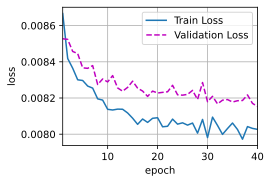

In [58]:
num_epochs = 40 # Number of training epochs

animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], legend = ['Train Loss', 'Validation Loss']) # Initialize animator for live plotting of loss

# Training and validation loop
for epoch in range(num_epochs):

    # Training
    model.train() # Set model to training mode, enable dropout/batchnorm updates
    metric = d2l.Accumulator(2)  # For accumulating training loss and number of examples
    for overlay, imgA, imgB in train_loader: # Iterate over training data
        overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device) # Move data to device
        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4 # Random weight between 0.4 and 0.6 for mixing
        overlay_rand = w * imgA + (1 - w) * imgB # Create random overlay
        optimizer.zero_grad() # Zero the gradients
        predA, predB = model(overlay_rand) # Forward pass, get predictions
        loss = separation_loss_l1(predA, predB, imgA, imgB) # Compute loss
        loss.backward() # Backward pass, compute gradients
        optimizer.step() # Update model parameters
        metric.add(loss.item(), overlay.size(0)) # Accumulate loss and number of examples
    avg_train_loss = metric[0] / metric[1] # Average training loss

    # Validation
    model.eval() # Set model to evaluation mode, disable dropout/batchnorm updates
    metric_val = d2l.Accumulator(2) # For accumulating validation loss and number of examples
    with torch.no_grad(): # No gradient calculation during validation
        for overlay, imgA, imgB in val_loader: # Iterate over validation data
            overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device) # Move data to device
            w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4 # Random weight between 0.4 and 0.6 for mixing
            overlay_rand = w * imgA + (1 - w) * imgB # Create random overlay
            predA, predB = model(overlay_rand) # Forward pass, get predictions
            loss = separation_loss_l1(predA, predB, imgA, imgB) # Compute loss
            metric_val.add(loss.item(), overlay.size(0)) # Accumulate loss and number of examples
    avg_val_loss = metric_val[0] / metric_val[1] # Average validation loss

    # Print epoch loss summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Update live plot
    animator.add(epoch+1, (avg_train_loss, avg_val_loss)) # Add data to animator for live plotting
    plt.pause(0.01) # Pause to update plot
    plt.show() # Show the plot

### Check Results

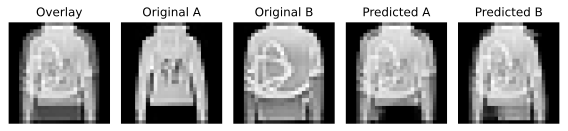

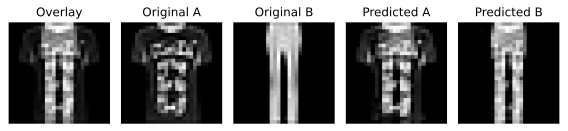

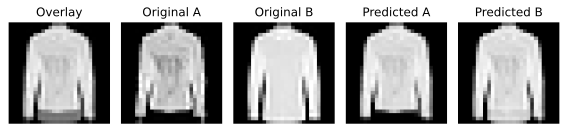

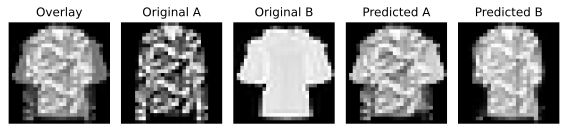

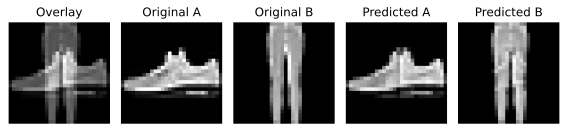

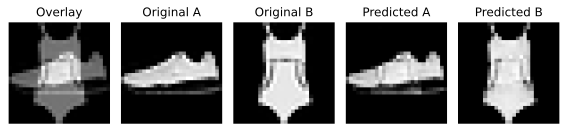

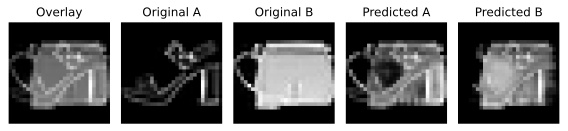

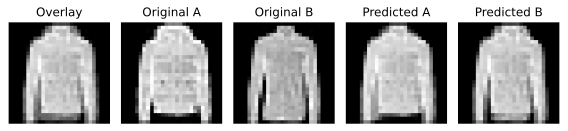

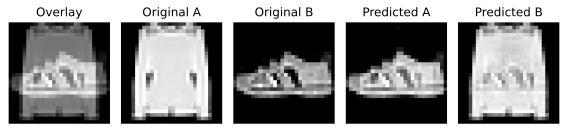

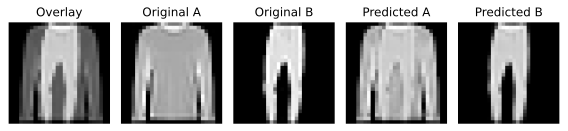

In [59]:
# Show results for 10 random samples from the overlay dataset
for _ in range(10):
    rand_index = random.randint(0, len(overlay_dataset) - 1) # Random index in the dataset
    show_overlay_results(model, overlay_dataset, index=rand_index) # Show overlay results for the random index

## Testing

### Testing Loop

In [60]:
model.eval() # Set model to evaluation mode, disable dropout/batchnorm updates
metric_test = d2l.Accumulator(2) # For accumulating test loss and number of examples

with torch.no_grad(): # No gradient calculation during testing
    # Iterate over test data
    for overlay, imgA, imgB in test_loader:
        overlay, imgA, imgB = overlay.to(device), imgA.to(device), imgB.to(device) # Move data to device
        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4 # Random weight between 0.4 and 0.6 for mixing
        overlay_rand = w * imgA + (1 - w) * imgB # Create random overlay
        predA, predB = model(overlay_rand) # Forward pass, get predictions
        loss = separation_loss_l1(predA, predB, imgA, imgB) # Compute loss
        metric_test.add(loss.item(), overlay.size(0)) # Accumulate loss and number of examples

avg_test_loss = metric_test[0] / metric_test[1] # Average test loss
print(f"Test Loss: {avg_test_loss:.4f}") # Print test loss

Test Loss: 0.0082


### Check Results

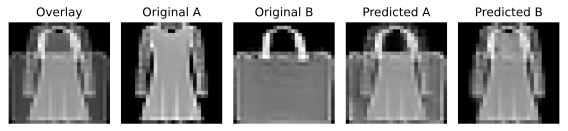

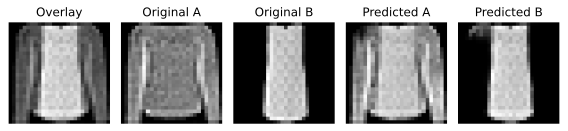

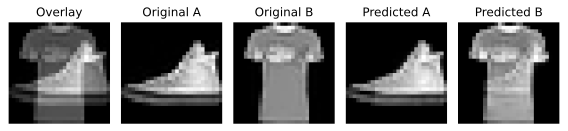

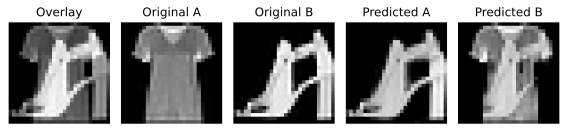

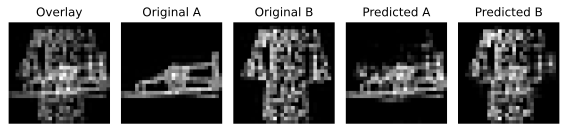

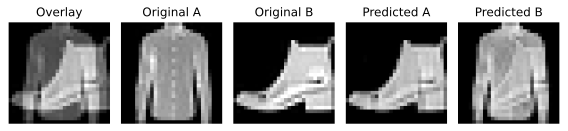

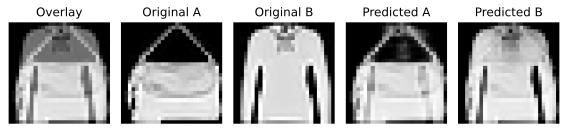

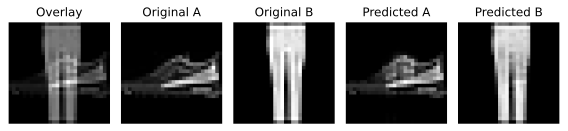

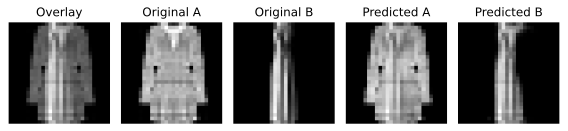

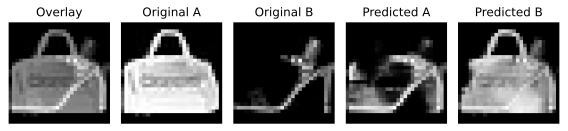

In [61]:
# Show overlay results for 10 random samples
for _ in range(10):
    rand_index = random.randint(0, len(overlay_dataset) - 1) # Random index in the dataset
    show_overlay_results(model, overlay_dataset, index=rand_index) # Show overlay results for the random index